# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
import progressbar
import datetime
import math
import json
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV



%matplotlib inline

plt.rcParams["figure.figsize"] = (9,7)

In [154]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio analysis

In [3]:
# Check shape and visualize 5 random rows
print("Portfolio shape: {} rows {} columns".format(portfolio.shape[0], portfolio.shape[1]))
portfolio

Portfolio shape: 10 rows 6 columns


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# Check informations about the portfolio df
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


#### Since the portfolio dataset only have 10 rows, we don't need analyse too much because we already seeing all the data.
#### We can already clean the dataset

# Portfolio clean
* Rename the column id to offer_id
* Rename the column duration to duration_days
* One hot encoding offer_type column
* One hot encoding channels column

In [5]:
def clean_portfolio(df=portfolio):
    """
    Function to clean up portfolio df
    
    Input: portfolio dataframe
    
    Output: cleaned portfolio dataframe
    """
    # Copy the dataframe
    portfolio_clean = df.copy()
    
    print('Portfolio shape before preprocessing: {} rows {} columns'.format(portfolio_clean.shape[0], portfolio_clean.shape[1]))
    
    # Rename id column
    portfolio_clean.rename(columns={'id': 'offer_id', 'duration':'duration_days'}, inplace=True)
    
    # Get dummies offer_type column and concat with the cleaned portfolio
    offer_types = pd.get_dummies(portfolio_clean['offer_type'])
    portfolio_clean = pd.concat([portfolio_clean, offer_types], axis=1)
    
    
    # Get dummies channels column and concat with the cleaned portfolio. 
    # Thanks to https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
    channels = pd.get_dummies(portfolio_clean['channels'].apply(pd.Series).stack()).sum(level=0)
    portfolio_clean = pd.concat([portfolio_clean, channels], axis=1)
    
    # Drop columns
    portfolio_clean.drop(columns=['channels', 'offer_type'], inplace=True)
    
    print('Portfolio shape after preprocessing: {} rows {} columns'.format(portfolio_clean.shape[0], portfolio_clean.shape[1]))
    
    # Return cleaned portfolio
    return portfolio_clean
    
portfolio_clean = clean_portfolio(portfolio)

portfolio_clean.head()

Portfolio shape before preprocessing: 10 rows 6 columns
Portfolio shape after preprocessing: 10 rows 11 columns


,reward,difficulty,duration_days,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


# Profile analysis

In [155]:
# Check shape and visualize 5 random rows
print("Profile shape: {} rows {} columns".format(profile.shape[0], profile.shape[1]))
profile.head()

Profile shape: 17000 rows 5 columns


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
# Check if the ID column has only unique values
len(profile.id.unique()) == profile.shape[0]

True

In [8]:
# Check the NaN values. 
print('Check NaN values in each column')
print(profile.isnull().sum())
print('-'*50)
print('Gender nulls values:', profile.gender.isnull().sum())
print('Age nulls(118) values:', sum(profile.age == 118))
print('Income nulls values:', profile.income.isnull().sum())
print('-'*50)

# The NaN values are all in the same rows. Lets remove them
print('Shape before drop NaN values:', profile.shape)
profile.dropna(inplace=True)
print('Shape after drop NaN values:', profile.shape)

Check NaN values in each column
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
--------------------------------------------------
Gender nulls values: 2175
Age nulls(118) values: 2175
Income nulls values: 2175
--------------------------------------------------
Shape before drop NaN values: (17000, 5)
Shape after drop NaN values: (14825, 5)


In [9]:
# Create new column year from became_member_on column

profile['year'] = profile['became_member_on'].apply(lambda s: int(str(s)[:4]))
profile.head()

,gender,age,id,became_member_on,income,year
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017


In [10]:
# Calculate min age and max age to cut the age column into range
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['age_range'] = pd.cut(profile['age'], (range(min_age_limit,max_age_limit + 10, 10)), right=False).astype('str')

profile.head()

,gender,age,id,became_member_on,income,year,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017,"[50, 60)"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017,"[70, 80)"
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018,"[60, 70)"
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018,"[60, 70)"
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017,"[50, 60)"


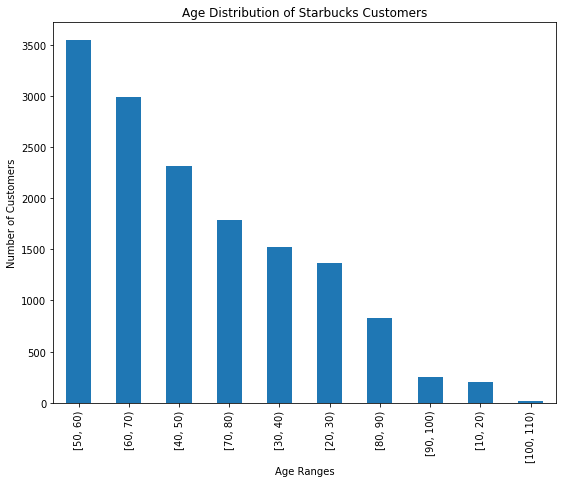

In [11]:
#Viewing the age ranges of our Starbucks customers
profile['age_range'].value_counts().plot(kind='bar');
plt.title('Age Distribution of Starbucks Customers');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

#### Most of the customers have the age between 50 and 60

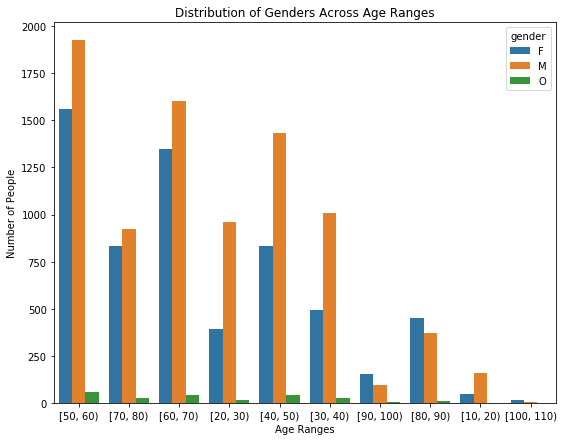

In [12]:
#Visualizing the gender distribution in a seaborn count plot
sns.countplot(data=profile, x='age_range', hue='gender');
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');

#### Here we observe that are more males than any other gender category and are more customer in the age range of 50-60 in all gender category.

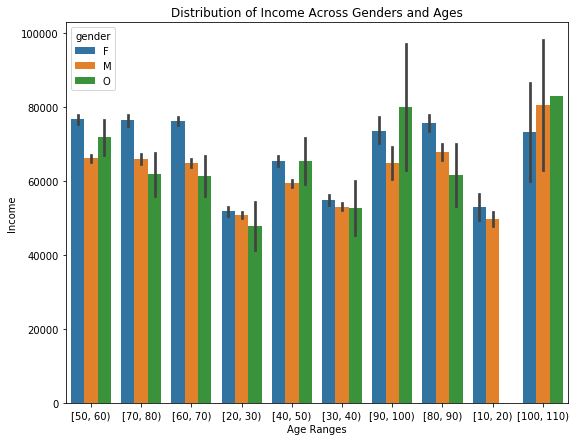

In [13]:
#Visualizing the gender, income and age range distribution in a bar plot
sns.barplot(data=profile, x='age_range', y='income', hue='gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');

#### Heve we can observe that females generally tend to have a higher income than men, even though most customers are men.

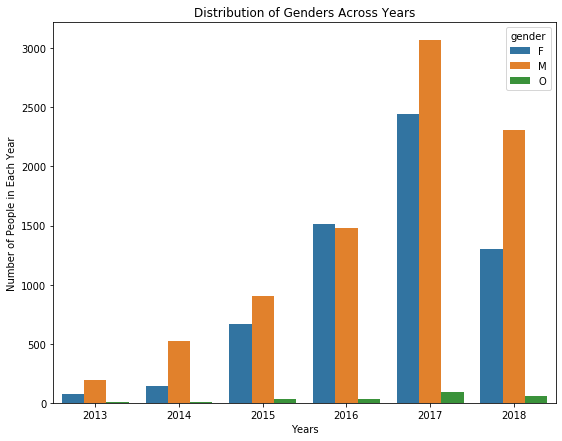

In [14]:
sns.countplot(data=profile, x='year', hue='gender');
plt.title('Distribution of Genders Across Years');
plt.xlabel('Years');
plt.ylabel('Number of People in Each Year');

#### The results show that there is an increasing trend in the number of customers over the years. It had its peak in 2017, however, in 2018 this trend started to decrease.

# Profile clean
* Rename the column id to customer_id
* One hot enconding age_range column
* One hot enconding gender column
* One hot enconding year column
* Drop columns age_range, gender, become_member_on, age and year

In [15]:
def clean_profile(df=profile):
    """
    Function to clean up profile df
    
    Input: profile dataframe
    
    Output: cleaned profile dataframe
    """
    
    # Copy the dataframe
    profile_clean = df.copy()
    
    print('Profile shape before preprocessing: {} rows {} columns'.format(profile_clean.shape[0], profile_clean.shape[1]))
    
    # rename id column to customer_id
    profile_clean.rename(columns={'id':'customer_id'}, inplace=True)
    
    # One hot enconding year
    years = pd.get_dummies(profile_clean['year'])
    profile_clean = pd.concat([profile_clean, years], axis=1)
    
    # One hot enconding gender
    genders = pd.get_dummies(profile_clean['gender'])
    profile_clean = pd.concat([profile_clean, genders], axis=1)

    # One hot enconding age_ranges
    age_ranges = pd.get_dummies(profile_clean['age_range'])
    profile_clean = pd.concat([profile_clean, age_ranges], axis=1)
    
    profile_clean.drop(columns=['became_member_on', 'age_range', 'gender', 'year', 'age'], axis=1, inplace=True)
    
    print('Profile shape after preprocessing: {} rows {} columns'.format(profile_clean.shape[0], profile_clean.shape[1]))
    
    return profile_clean

    
profile_clean = clean_profile(profile)
profile_clean.head()

Profile shape before preprocessing: 14825 rows 7 columns
Profile shape after preprocessing: 14825 rows 21 columns


,customer_id,income,2013,2014,2015,2016,2017,2018,F,M,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


# Transcript Analysis

In [156]:
# Check shape and visualize 5 random rows
print("Transcript shape: {} rows {} columns".format(transcript.shape[0], transcript.shape[1]))
transcript.head()

Transcript shape: 306534 rows 4 columns


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
# check unique values on event column
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [18]:
# Check the value counts of unique event
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [19]:
# Check the types of key in the value column
{v for item in transcript.value.values for v in item}

{'amount', 'offer id', 'offer_id', 'reward'}

# Transcript clean
* Rename the column person to customer_id
* One hot encoding event column
* Create new columns: amount and offer_id from value column
* Drop transactions rows whose customer_id is not in profile dataframe
* Convert time column to days
* Separate offers data and transactions data
* Drop duplicates rows

In [20]:
def clean_transcript(transcript):
    """
    Function to clean up transcript df
    
    Input: transcript dataframe
    
    Output: transcript cleaned, offers df and transactions df
    """
    
    transcript_clean = transcript.copy()
    
    print('Transcript shape before preprocessing: {} rows {} columns'.format(transcript_clean.shape[0], transcript_clean.shape[1]))
    
    transcript_clean.rename(columns={'person':'customer_id'}, inplace=True)
    
    transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['offer_id', 'offer id'] else None)
    
    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['amount'] else None)
    
    transcript_clean.amount.astype('float')

    # drop value column
    transcript_clean.drop(columns=['value'], inplace=True)
    
    transcript_clean = transcript_clean[transcript_clean.customer_id.isin(profile_clean.customer_id)]
    
    transcript_clean['time'] /= 24.0
    
    transcript_clean.drop_duplicates(inplace=True)

    transcript_clean.reset_index(drop=True, inplace=True)
    
    transaction_df = transcript_clean[transcript_clean.event=='transaction'].copy()
    transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
    
    offers_df = transcript_clean[transcript_clean.event!='transaction'].copy()
    events = pd.get_dummies(offers_df['event'])
    offers_df = pd.concat([offers_df, events], axis=1)
    offers_df.drop(columns=['event', 'amount'], inplace=True)
    
    offers_df.columns = offers_df.columns.str.replace(' ', '_')
    
    print('Transactions df shape: {} rows {} columns'.format(transaction_df.shape[0], transaction_df.shape[1]))
    print('Offers df shape: {} rows {} columns'.format(offers_df.shape[0], offers_df.shape[1]))
    
    return transaction_df, offers_df

    
transactions_clean, offers_clean = clean_transcript(transcript)

Transcript shape before preprocessing: 306534 rows 4 columns
Transactions df shape: 123957 rows 3 columns
Offers df shape: 148431 rows 6 columns


In [21]:
transactions_clean

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
272382,24f56b5e1849462093931b164eb803b5,29.75,22.64
272384,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
272386,a00058cf10334a308c68e7631c529907,29.75,3.61


In [22]:
offers_clean

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
...,...,...,...,...,...,...
272343,84fb57a7fe8045a8bf6236738ee73a0f,29.75,5a8bc65990b245e5a138643cd4eb9837,0,0,1
272350,abc4359eb34e4e2ca2349da2ddf771b6,29.75,3f207df678b143eea3cee63160fa8bed,0,0,1
272363,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
272365,8431c16f8e1d440880db371a68f82dd0,29.75,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


# Combine all data

In [29]:
# https://progressbar-2.readthedocs.io/en/latest/index.html#introductionn
# https://progressbar-2.readthedocs.io/en/latest/progressbar.bar.html

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['offer_received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['offer_completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['offer_viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration_days'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    
    column_list = ['time', 'offer_id', 'customer_id', 'total_amount',
                       'offer_successful', 'difficulty', 'duration_days',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web',
                       'income', 2013, 2014, 2015, 2016, 2017, 2018, 
                       'F', 'M', 'O', '[10, 20)', '[20, 30)', '[30, 40)', 
                       '[40, 50)','[50, 60)', '[60, 70)', '[70, 80)', 
                       '[80, 90)', '[90, 100)', '[100, 110)']
    
    data[column_list]
    
    return data

In [30]:
all_data = combine_data(profile_clean, portfolio_clean, offers_clean, transactions_clean)

 [Elapsed Time: 0:08:25] |##################################| (Time:  0:08:25) 


In [31]:
all_data

,offer_id,customer_id,time,total_amount,offer_successful,reward,difficulty,duration_days,bogo,discount,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1,0,...,0,0,0,0,0,0,0,1,0,0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,1,0,...,0,0,0,0,0,0,0,1,0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,5,5,5,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,2,10,7,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,24.0,34.04,0,2,10,7,0,1,...,0,0,0,0,0,1,0,0,0,0
66497,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,24.0,19.92,0,0,0,3,0,0,...,0,0,0,0,1,0,0,0,0,0
66498,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,24.0,28.42,0,5,5,7,1,0,...,0,0,0,0,0,0,1,0,0,0
66499,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,24.0,75.84,1,3,7,7,0,1,...,0,0,0,0,0,1,0,0,0,0


In [33]:
# save all data
all_data.to_csv('all_data_combine_clean.csv', index=False)

In [36]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in all_data.columns if elem not in column_ordering])

all_data = all_data[column_ordering]
all_data = all_data.drop(columns=['time', 'customer_id', 'email', 'informational'])
all_data.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration_days,bogo,discount,mobile,social,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [73]:
all_data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

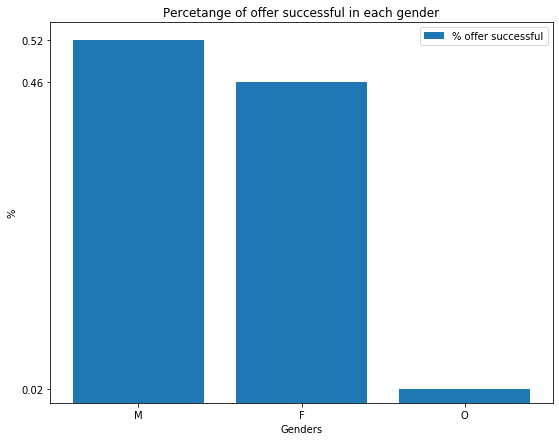

In [151]:
genders_data = []
for x in ['M', 'F', 'O']:
    genders_data.append((x, np.round(all_data.groupby(by='offer_successful')[x].sum()[1] / all_data.offer_successful.value_counts()[1], 2))) 

labels, ys = zip(*genders_data)
xs = np.arange(len(labels)) 
width = 0.8
plt.bar(xs, ys, width, align='center')
plt.legend(['% offer successful'])
plt.title('Percetange of offer successful in each gender')
plt.ylabel('%')
plt.xlabel('Genders')
plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()

#### Here we can see that the most successful offers were offered for males

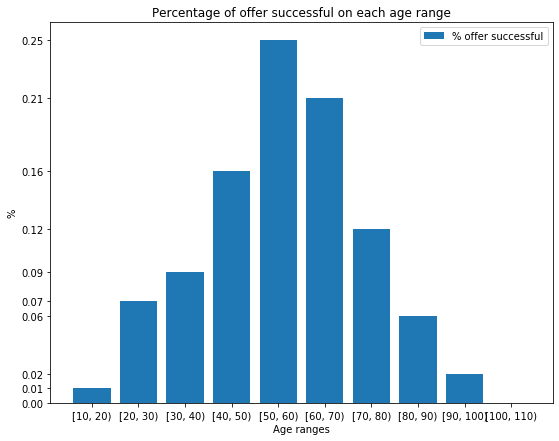

In [149]:
age_data = []
for x in ['[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
          '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)',
          '[90, 100)', '[100, 110)']:
    age_data.append((x, np.round(all_data.groupby(by='offer_successful')[x].sum()[1] / all_data.offer_successful.value_counts()[1], 2)))

labels, ys = zip(*age_data)
xs = np.arange(len(labels)) 
width = 0.8
plt.bar(xs, ys, width, align='center')
plt.legend(['% offer successful'])
plt.title('Percentage of offer successful on each age range')
plt.ylabel('%')
plt.xlabel('Age ranges')
plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()

#### Here we can see that the most successful offers were offered for the age ranges 40 - 70 years old customers.

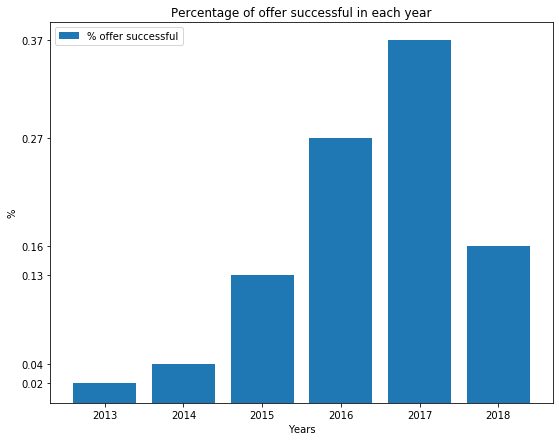

In [148]:
years_data = []
for x in [2013, 2014, 2015, 2016, 2017, 2018]:
    years_data.append((x, np.round(all_data.groupby(by='offer_successful')[x].sum()[1] / all_data.offer_successful.value_counts()[1], 2)))

labels, ys = zip(*years_data)
xs = np.arange(len(labels)) 
width = 0.8
plt.bar(xs, ys, width, align='center')
plt.legend(['% offer successful'])
plt.title('Percentage of offer successful in each year')
plt.ylabel('%')
plt.xlabel('Years')
plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()

#### Here we can see that the most successful offers were offered in the year 2017, followed by 2016 and decrease in the year 2018. That was expected since the number of customers that start to be a member follow the same distribution.

# Build Models

In [108]:
# factors/features that influence the label variable
features = all_data.drop(columns=['offer_successful'])

# label variable to predict
label = all_data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [152]:
X_train.shape, X_test.shape

((46550, 28), (19951, 28))

## Naive predictor performance

In [109]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


## Logistic Regression model

*  Results suggest that a logistic regression model's accuracy and f1-score is better than the naive predictor
* Accuracy
    * Naive predictor: 0.471
    * Logistic regression: 0.722
* F1-score
    * Naive predictor: 0.640
    * Logistic regression: 0.717

In [110]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   13.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False,
                   scoring=make_scor

In [124]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [125]:
# Evaluate on train data
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.716


(0.7220837808807734, 0.7162627481083451)

In [126]:
# Evaluate on test data
evaluate_model_performance(lr_random.best_estimator_, X_test, y_test)

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.717


(0.7222695604230365, 0.7169926962561928)

## Random Forest Model

*  Results suggest that a random forest model's accuracy and f1-score is better than the naive predictor and logistic regression
* Accuracy
    * Naive predictor: 0.471
    * Logistic regression: 0.722
    * Random forest 0.731
* F1-score
    * Naive predictor: 0.640
    * Logistic regression: 0.717
    * Random forest 0.724

In [116]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   33.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  3.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [127]:
# Evaluate on train data
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.746
RandomForestClassifier model f1-score: 0.739


(0.7461009667024705, 0.7385581878912558)

In [128]:
# Evaluate on test data
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.731
RandomForestClassifier model f1-score: 0.724


(0.7310410505739061, 0.7243115495273325)

In [145]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest']

model_performance.append((naive_predictor_accuracy,
                          naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_,
                                                    X_test,
                                                    y_test))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_,
                                                    X_test,
                                                    y_test))


model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.717
RandomForestClassifier model accuracy: 0.731
RandomForestClassifier model f1-score: 0.724


,classifiertype,accuracy,f1score
0,randomforest,0.731041,0.724312
1,logisticregression,0.722270,0.716993
2,naivepredictor,0.470763,0.640161


In [146]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Text(0.5, 1.0, '')

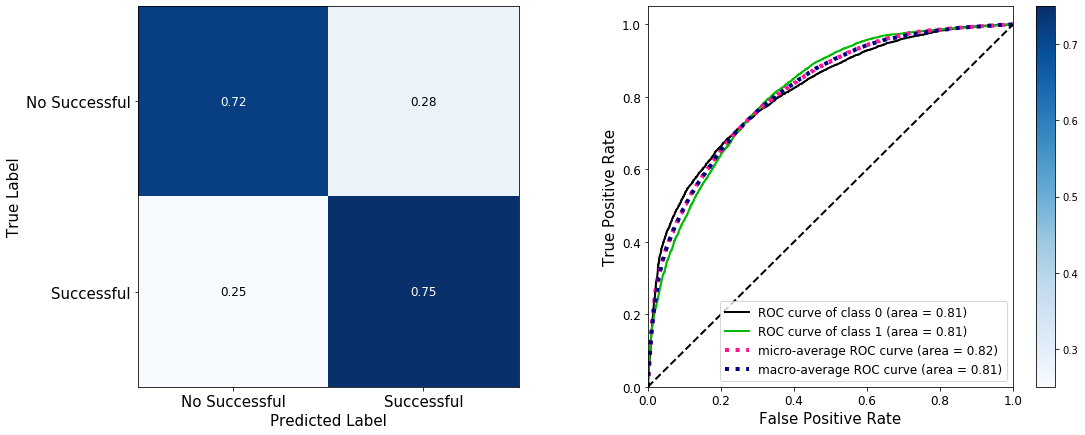

In [142]:
y_probs = rf_random.best_estimator_.predict_proba(X_test)
y_pred = np.argmax(y_probs, axis=1)

target_names = ['No Successful', 'Successful']

f, ax = plt.subplots(figsize=(18, 7), nrows=1, ncols=2)

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax[0], text_fontsize='large')
ax[0].set_yticklabels(target_names, fontsize=15)
ax[0].set_xticklabels(target_names, fontsize=15)
ax[0].set_xlabel('Predicted Label', fontsize=15)
ax[0].set_ylabel('True Label', fontsize=15)
ax[0].set_title('')

skplt.metrics.plot_roc(y_test, y_probs, ax=ax[1], text_fontsize='large')
ax[1].set_xlabel('False Positive Rate', fontsize=15)
ax[1].set_ylabel('True Positive Rate', fontsize=15)
ax[1].set_title('')

# Conclusion

#### The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has four steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of a naive model that assumed all customer offers were successful. Third, I compared the performance of logistic regression, random forest, and gradient boosting models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. Fourth, I refined random forest model hyperparameters using a grid search. My analysis suggests that the resulting random forest model has on test data accuracy of 0.731 and an F1-score of 0.724 suggests that the random forest model I constructed did not overfit the training data.